# 1. Executive Summary
The goal of this project is to predict individual medical insurance costs based on demographic and health-related factors. Accurately forecasting medical expenses is crucial for insurance companies to set competitive yet profitable premiums and for policyholders to understand their potential financial risks.

In this notebook, we will:
1.  **Explore the dataset** to uncover patterns and correlations.
2.  **Analyze key drivers** of medical costs (e.g., smoking, BMI, age).
3.  **Build a Machine Learning model** (Random Forest Regressor) to predict costs with high accuracy.
4.  **Interpret the results** to provide actionable business insights.

# 2. Dataset Overview
The dataset contains 1,338 records with the following features:
* **Age:** Age of the primary beneficiary.
* **Sex:** Gender (male/female).
* **BMI:** Body mass index (kg/m²).
* **Children:** Number of children covered by health insurance.
* **Smoker:** Smoking status (yes/no).
* **Region:** Residential area in the US (northeast, southeast, southwest, northwest).
* **Charges:** Individual medical costs billed by health insurance (Target Variable).

In [1]:
# Environment Setup & Library Imports

# Standard libraries for numerical computing and data manipulation
import numpy as np
import pandas as pd

# Libraries for static statistical data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries and configuration for interactive visualizations
# Cufflinks binds Plotly directly to pandas DataFrames
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Initialize Plotly for offline usage within the notebook context
# This allows interactive plots to render locally without server calls
init_notebook_mode(connected=True)
cf.go_offline()

# Jupyter command to ensure static Matplotlib plots render inline
%matplotlib inline

In [2]:
# Load the primary dataset into a pandas DataFrame from the specified CSV file
dataframe = pd.read_csv('insurance.csv')

# Create a conventional shorter alias (df) for the DataFrame
df = dataframe

# Display the first five rows of the dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Generate a concise summary of the DataFrame structure.
# This output allows for a quick assessment of:
# 1. The presence of missing values (by comparing non-null counts to the total entries).
# 2. The data types (dtypes) of each column to ensure they match the expected format.
# 3. The memory usage of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Perform an explicit check for missing values across all columns.
# Although .info() suggested consistent non-null counts, this step provides 
# a clear, quantitative summary of nulls to confirm data integrity.
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# 3. Exploratory Data Analysis (EDA)
It is essential to understand the distribution of our data and identify potential outliers. We will start by analyzing the statistical distribution of the numerical features.

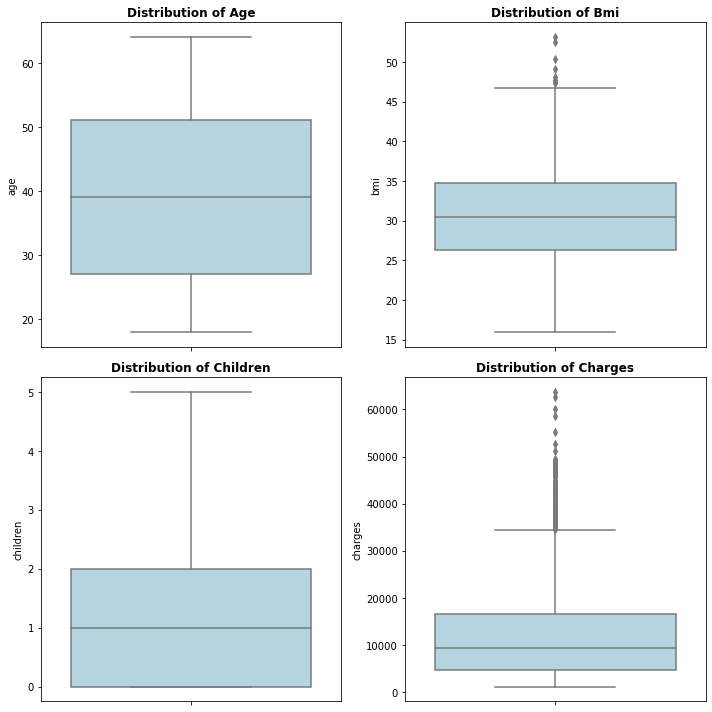

In [5]:
# List of numerical columns to visualize using boxplots
cols_to_plot = ['age', 'bmi', 'children', 'charges']

# Initialize the 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate simultaneously over the flattened axes array and the column names.
for ax, col in zip(axes.flatten(), cols_to_plot):
    # Use Seaborn's boxplot for statistical representation
    sns.boxplot(y=df[col], ax=ax, color='lightblue')
    
    # Set capitalized titles for each subplot
    ax.set_title(f'Distribution of {col.capitalize()}', fontsize=12, fontweight='bold')
    
    # Remove standard x-label to reduce clutter, as the title explains the content
    ax.set_xlabel('')

# Adjust layout to prevent overlap between subplots
plt.tight_layout()
plt.show()

The initial boxplots reveal that **`bmi`** and **`charges`** are the only variables with significant outliers.

These outliers are not errors; they represent **high-risk, high-cost events** that disproportionately impact financial outcomes.

Therefore, we will prioritize the investigation of these two variables to:
1.  **Characterize the High-Cost Segment:** Understand *who* generates these extreme charges (e.g., is it driven by chronic conditions or lifestyle choices?).
2.  **Assess Health Risk:** Determine if the extreme BMI values correlate directly with the highest charges, helping us identify specific risk groups within the population.

## Deep Dive: BMI Analysis

We will now examine the distribution of the **Body Mass Index (BMI)** in detail. Since BMI is a critical health indicator, understanding its spread and identifying extreme values is essential for accurate risk assessment.

**Analysis Steps:**
1.  **Interactive Visualization:** We will use an interactive boxplot (via `iplot`) to visually inspect the distribution, identify the Interquartile Range (IQR), and pinpoint specific outlier values.
2.  **Statistical Summary:** We will generate descriptive statistics using `describe()` to obtain precise metrics on central tendency (mean/median) and dispersion (standard deviation/min/max).

In [6]:
# Generate an interactive boxplot for the 'bmi' column using Cufflinks/Plotly.
# Interactive plots are superior for EDA as they allow hovering to see exact
# quartile values (Q1, Median, Q3) and specific outlier data points.
df['bmi'].iplot(
    kind='box', 
    title='Interactive Distribution of Body Mass Index (BMI)',
    yTitle='BMI Value',
    color='royalblue')

In [7]:
# Generate descriptive statistics for the 'bmi' column to analyze its distribution.
# This summary includes central tendency (mean, median), dispersion (std), 
# and the five-number summary (min, 25%, 50%, 75%, max).
# We round the results to 2 decimal places for cleaner, report-ready output.
df['bmi'].describe().round(2)

count    1338.00
mean       30.66
std         6.10
min        15.96
25%        26.30
50%        30.40
75%        34.69
max        53.13
Name: bmi, dtype: float64

#### 📌 Key Takeaways: BMI Distribution

The analysis of the `bmi` feature reveals specific characteristics of our population:

* **High Average BMI:** The mean BMI is approximately **30.6**, placing the average policyholder in the **Obesity** category.
* **Significant Outliers:** We observe pronounced outliers with values exceeding **45**.
* **Distribution:** The data is moderately dispersed, with the majority of individuals falling between **26 and 35**. There is a slight right skew, which is typical for weight-related biometric data.

**Decision:**
We will **retain all outliers**. Even the maximum values observed are biologically plausible (consistent with **Class III / Extreme Obesity**) and represent a valid high-risk segment of the population.

**Population Insight:**
This confirms that we are dealing with a population where obesity is prevalent. Since a significant portion of the dataset is already overweight or obese, this specific distribution might prematurely suggest that BMI alone is not the dominant differentiator for medical charges, contrary to initial intuition.

## Deep Dive: Charges Analysis

Finally, we will analyze the distribution of **`charges`**, which serves as our target variable. Understanding the spread of medical costs is fundamental to establishing a baseline for our predictive model and identifying high-cost outliers.

**Analysis Steps:**
1.  **Interactive Visualization:** We will deploy an interactive boxplot to examine the cost distribution, specifically looking for the "long tail" of high-cost claims and determining the threshold for extreme financial risk.
2.  **Statistical Summary:** We will use `describe()` to quantify the skewness (comparing mean vs. median) and define the range of insurance premiums.

In [8]:
# Create an interactive boxplot for the 'charges' column.
# Visualizing cost distributions interactively is particularly useful to:
# 1. Identify high-cost outliers (top of the whisker).
# 2. Understand the spread of medical costs across the customer base.
df['charges'].iplot(
    kind='box', 
    title='Interactive Distribution of Insurance Charges',
    yTitle='Charges (USD)',
    color='green')

In [9]:
# Generate descriptive statistics for the 'charges' column to analyze its distribution.
# This summary includes central tendency (mean, median), dispersion (std), 
# and the five-number summary (min, 25%, 50%, 75%, max).
# We round the results to 2 decimal places for cleaner, report-ready output.
df['charges'].describe().round(2)

count     1338.00
mean     13270.42
std      12110.01
min       1121.87
25%       4740.29
50%       9382.03
75%      16639.91
max      63770.43
Name: charges, dtype: float64

#### 📌 Key Takeaways: Medical Charges Distribution

The analysis of the `charges` variable reveals critical insights into the cost structure:

* **Skewed Distribution:** The mean charge **13,270 USD** is significantly higher than the median **9,382 USD**, indicating a strong right skew. This suggests that while most policyholders incur moderate costs, a smaller group drives up the average.
* **High Variance:** With a standard deviation of **12,110 USD**, there is substantial variability in medical expenses, reflecting diverse risk profiles within the population.
* **Extreme Outliers:** The maximum charge reaches **63,770 USD**, which is nearly 5 times the mean. The upper quartile (75%) is only **16,639 USD**, meaning the top 25% of claimants account for a disproportionate share of total costs.

**Decision:**
We will **retain these outliers**. In insurance, these high-cost cases are not anomalies but rather the most critical data points for risk assessment. They likely represent complex medical cases or chronic conditions (potentially linked to smoking or high BMI).

#### Feature Engineering: BMI Categorization

To deepen our analysis, we will perform **Feature Engineering** by transforming the continuous `bmi` variable into standardized clinical categories (based on WHO guidelines).
* **Source:** [World Health Organization - BMI Classification](https://www.who.int/data/gho/data/themes/topics/topic-details/GHO/body-mass-index)

**Objective:**
This engineered feature (`bmi_cat`) will be utilized in our **subsequent visualizations** to segment the population.

In [10]:
# 1. Define Bin Edges and Labels
# We establish cut-off points based on standard World Health Organization (WHO) guidelines.
# - Underweight: < 18.5
# - Normal: 18.5 - 24.9
# - Overweight: 25.0 - 29.9
# - Obese: 30.0 - 34.9
# - Extremely Obese: > 35.0 (Captures the outliers identified in EDA)
bins = [0, 18.5, 24.9, 29.9, 34.9, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']

# 2. Discretize Variable
# Transform the continuous 'bmi' feature into categorical bins using pd.cut.
# - right=True: Bins include the rightmost edge (e.g., exactly 24.9 falls into 'Normal').
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=True)

# 3. Verification
# Inspect the first rows to ensure the 'bmi_cat' column was assigned correctly.
# df.head()

# Dashboard 1 - Distributions

To gain a holistic understanding of the insured population, we will generate a **multi-panel dashboard**. This visualization strategy allows us to simultaneously inspect key distributions across three critical dimensions:

1.  **Demographics:** Assessing the balance of gender, age, family size (children), and geographic region.
2.  **Risk Factors:** Visualizing the prevalence of smoking and obesity, which are major drivers of medical risk.
3.  **Cost Baseline:** Analyzing the density of medical charges separated by gender to detect initial disparities.

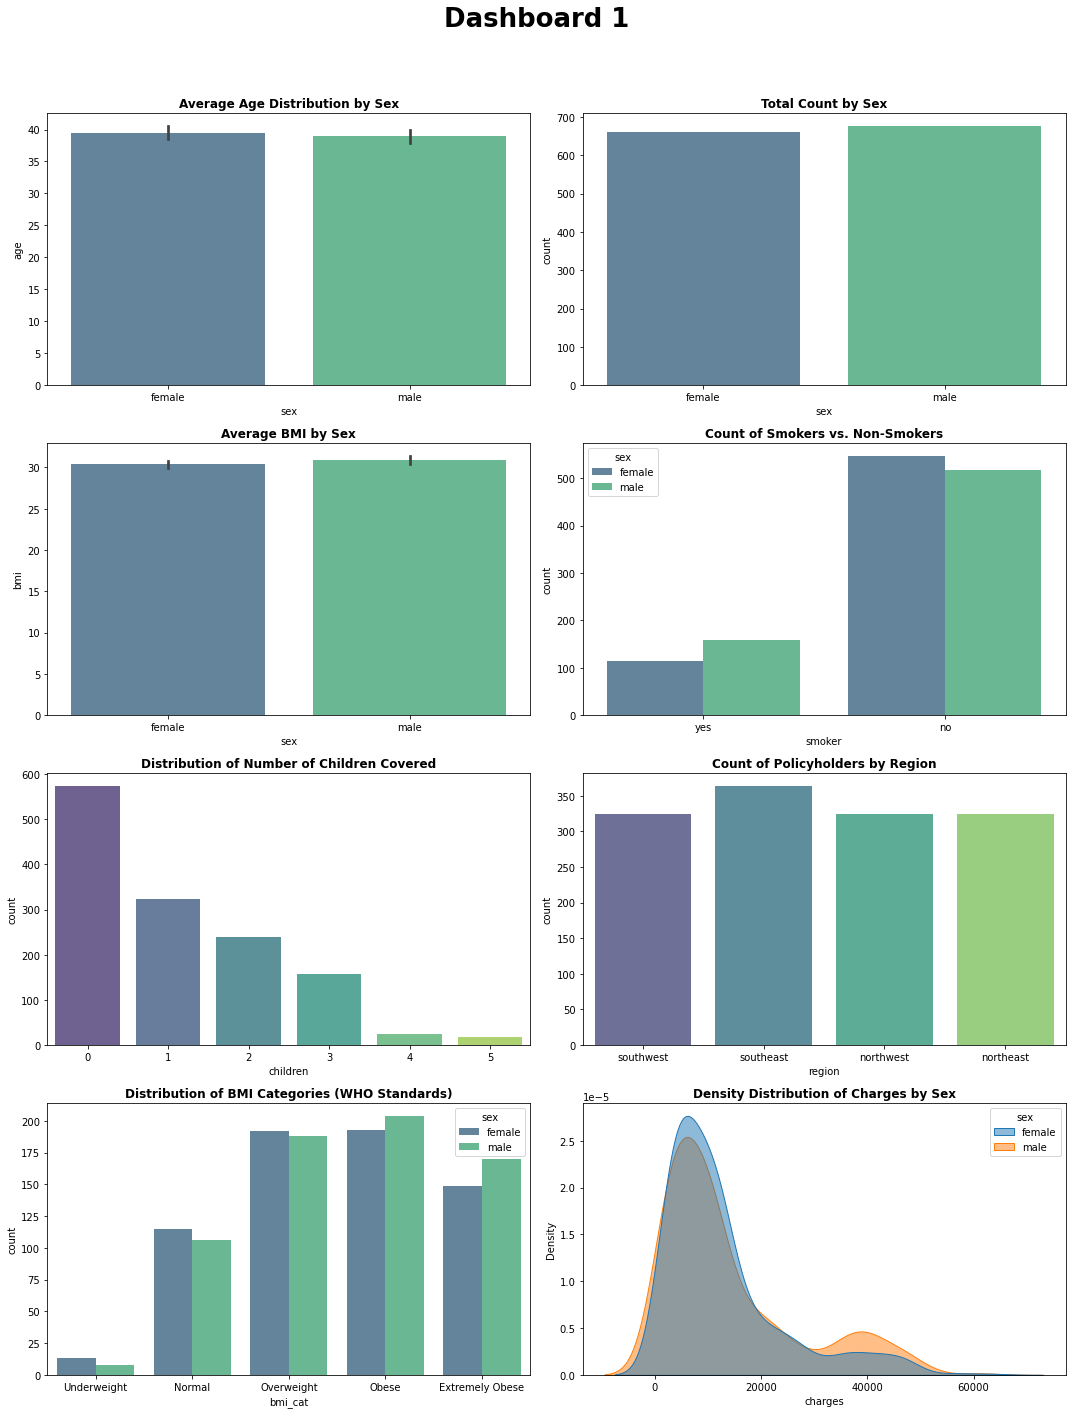

In [13]:
# Initialize a 4x2 grid of subplots with a larger figure size for clarity
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Define a consistent color palette for categorical plots
palette = 'viridis'

# --- Row 1 ---

# Plot 1: Average Age by Sex
# Uses a barplot to compare the mean age between genders (with confidence intervals).
sns.barplot(data=df, x='sex', y='age', palette=palette, alpha=0.8, ax=axes[0,0])
axes[0,0].set_title('Average Age Distribution by Sex', fontsize=12, fontweight='bold')

# Plot 2: Count of Individuals by Sex
# Checks for gender balance in the dataset.
sns.countplot(data=df, x='sex', palette=palette, alpha=0.8, ax=axes[0,1])
axes[0,1].set_title('Total Count by Sex', fontsize=12, fontweight='bold')


# --- Row 2 ---

# Plot 3: Average BMI by Sex
# compares metabolic health indicators across genders.
sns.barplot(data=df, x='sex', y='bmi', palette=palette, alpha=0.8, ax=axes[1,0])
axes[1,0].set_title('Average BMI by Sex', fontsize=12, fontweight='bold')

# Plot 4: Smoker Distribution
# Visualizes the proportion of smokers.
sns.countplot(data=df, x='smoker', hue='sex', palette=palette, alpha=0.8, ax=axes[1,1])
axes[1,1].set_title('Count of Smokers vs. Non-Smokers', fontsize=12, fontweight='bold')


# --- Row 3 ---

# Plot 5: Distribution of Number of Children
sns.countplot(data=df, x='children', palette=palette, alpha=0.8, ax=axes[2,0])
axes[2,0].set_title('Distribution of Number of Children Covered', fontsize=12, fontweight='bold')

# Plot 6: Regional Distribution
# Checks if the data is geographically balanced.
sns.countplot(data=df, x='region', palette=palette, alpha=0.8, ax=axes[2,1])
axes[2,1].set_title('Count of Policyholders by Region', fontsize=12, fontweight='bold')


# --- Row 4 ---

# Plot 7: BMI Category Distribution
# Visualizes the prevalence of obesity within the dataset.
sns.countplot(data=df, x='bmi_cat', hue='sex', palette=palette, alpha=0.8, ax=axes[3,0])
axes[3,0].set_title('Distribution of BMI Categories (WHO Standards)', fontsize=12, fontweight='bold')

# Plot 8: Charges Distribution by Sex (KDE)
# A Kernel Density Estimate (KDE) plot to show the shape of the cost distribution.
# We separate by sex to see if gender influences the probability of higher charges.
sns.kdeplot(data=df, x='charges', hue='sex', fill=True, alpha=0.5, ax=axes[3,1])
axes[3,1].set_title('Density Distribution of Charges by Sex', fontsize=12, fontweight='bold')

# Global Title
fig.suptitle('Dashboard 1', fontsize=26, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 📊 Dashboard 1 Summary

The exploratory analysis of the dataset reveals a demographically balanced but medically high-risk population. The data structure supports robust modeling due to even distribution across key categorical variables, though specific health indicators suggest a skew toward higher medical costs.

**1. Demographic Profile & Data Integrity**
* **Balance:** The dataset is exceptionally well-balanced regarding **Gender** (approx. 50/50 split) and **Region** (nearly equal distribution across four quadrants, with a slight uptick in the Southeast). This lack of bias suggests that predictive models built on this data will generalize well across these demographics.
* **Dependents:** The population skews towards smaller families, with the majority of policyholders covering **zero to one child**. The count decreases consistently as the number of children increases.

**2. Health Risk Indicators (Key Drivers)**
* **Obesity Epidemic:** The most concerning trend is the **Body Mass Index (BMI)** profile. The average BMI for both genders exceeds 30, placing the average policyholder in the "Obese" category according to WHO standards. The bar chart explicitly confirms that the "Obese" and "Overweight" categories vastly outnumber "Normal" weight individuals. This is a primary risk driver for higher medical claims.
* **Smoking Status:** Smokers represent a minority of the dataset (approx. 20%). However, given the known correlation between smoking and health costs, this minority likely drives the high-cost "outliers" seen in the charge distribution.

**3. Financial Implications (Charges)**
* **Cost Distribution:** The "Density Distribution of Charges" plot reveals a classic **right-skewed distribution** (Positive Skew).
    * **Majority:** Most policyholders incur relatively low charges (peak around \$10,000).
    * **High-Risk Segment:** There is a distinct secondary "hump" or mode around the \$40,000 mark. This multi-modal distribution suggests distinct subgroups within the data—likely differentiating between healthy non-smokers (low cost) and high-risk individuals (smokers or high BMI) who incur significantly higher costs.

**Conclusion & Next Steps**
The dataset portrays a population where **metabolic health (BMI)** is the dominant risk factor in terms of volume, while the distribution of charges suggests that a specific subset of users (likely interacting with smoking status) drives the most significant costs. Future analysis should reveal more details on the interaction between **BMI** and **Smoking** to accurately forecast high-value claims.

## Correlation Analysis
Now that we have visualized individual distributions, we need to quantify the relationships between variables. We will use a Correlation Matrix to identify which features have the strongest linear relationship with our target variable (`charges`).

*Note: Categorical variables (Sex, Smoker, Region) will be encoded numerically for this analysis.*

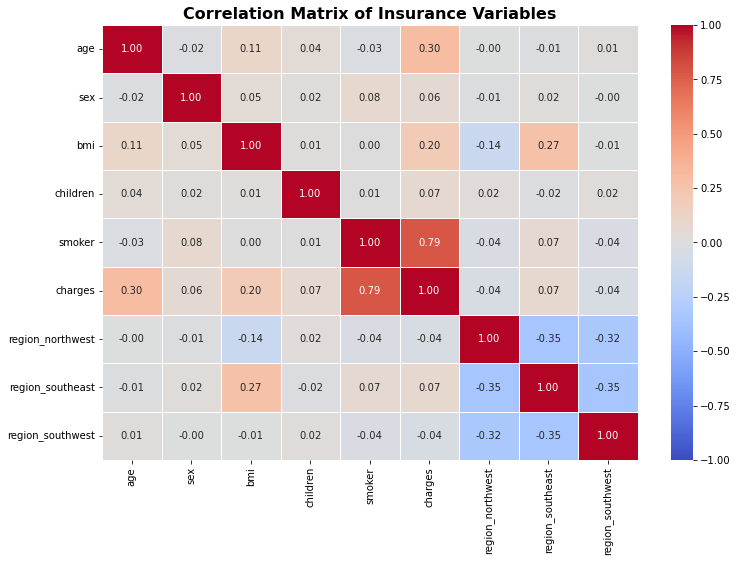

In [19]:
# Create a copy to avoid modifying the original dataframe in memory
df_encoded = df.copy()

# Drop 'bmi_cat' if it exists. 
# We prefer the continuous 'bmi' variable for correlation analysis over the categorical version
# to avoid redundancy and information loss.
if 'bmi_cat' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['bmi_cat'])

# Convert categorical variables into numeric formats:

# One-Hot Encoding for 'region':
# We use 'drop_first=True' to prevent the "Dummy Variable Trap" (multicollinearity),
# where one variable can be predicted perfectly from the others.
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

# Binary Mapping for 'smoker' and 'sex':
# Transforming these into 1/0 is necessary for correlation calculation and model training.
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})


# Correlation Matrix Visualization
plt.figure(figsize=(12, 8))

# Calculate correlation only on numeric columns to ensure stability
corr_matrix = df_encoded.select_dtypes(include='number').corr()

# Plot the heatmap
# annot=True: Displays the correlation coefficients on the map for precise reading.
# vmin=-1, vmax=1: Ensures the color scale is centered at 0 (neutral), 
# making strong positive (red) and negative (blue) correlations instantly visible.
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

plt.title('Correlation Matrix of Insurance Variables', fontsize=16, fontweight='bold')
plt.show()

### 📊 Correlation Matrix Summary

Based on the heatmap, we can derive the following conclusions regarding the relationships between variables:

* **Primary Cost Driver:** The target variable `charges` shows a **strong positive correlation (0.79)** with `smoker`. This confirms that smoking status is the most significant predictor of medical costs in this dataset.
* **Secondary Drivers:** There are **moderate correlations** between `charges` and `age` (0.3) as well as `bmi` (0.2), indicating that costs tend to increase as policyholders get older or have a higher body mass index.
* **Low Impact Features:** Variables such as `sex`, `children`, and `region` exhibit **negligible correlations (< 0.1)** with medical charges, suggesting they have a minimal linear impact on the cost.
* **Regional Pattern:** An interesting interaction is observed between `region_southeast` and `bmi` **(0.27)**. This suggests that policyholders in the Southeast region tend to have a higher BMI compared to other regions.

## Dashboard 2 - BMI Analysis

In this section, we generate a comprehensive dashboard to investigate the relationships between **Body Mass Index (BMI)** and other key variables.

**Objective:**
We aim to answer two critical questions:
1.  **Demographic Correlations:** Is BMI distributed differently across age groups, genders, regions, or family sizes?
2.  **Cost Interaction:** How does BMI interact with **smoking status** to impact medical charges? This relationship is vital for identifying high-risk compounding factors.

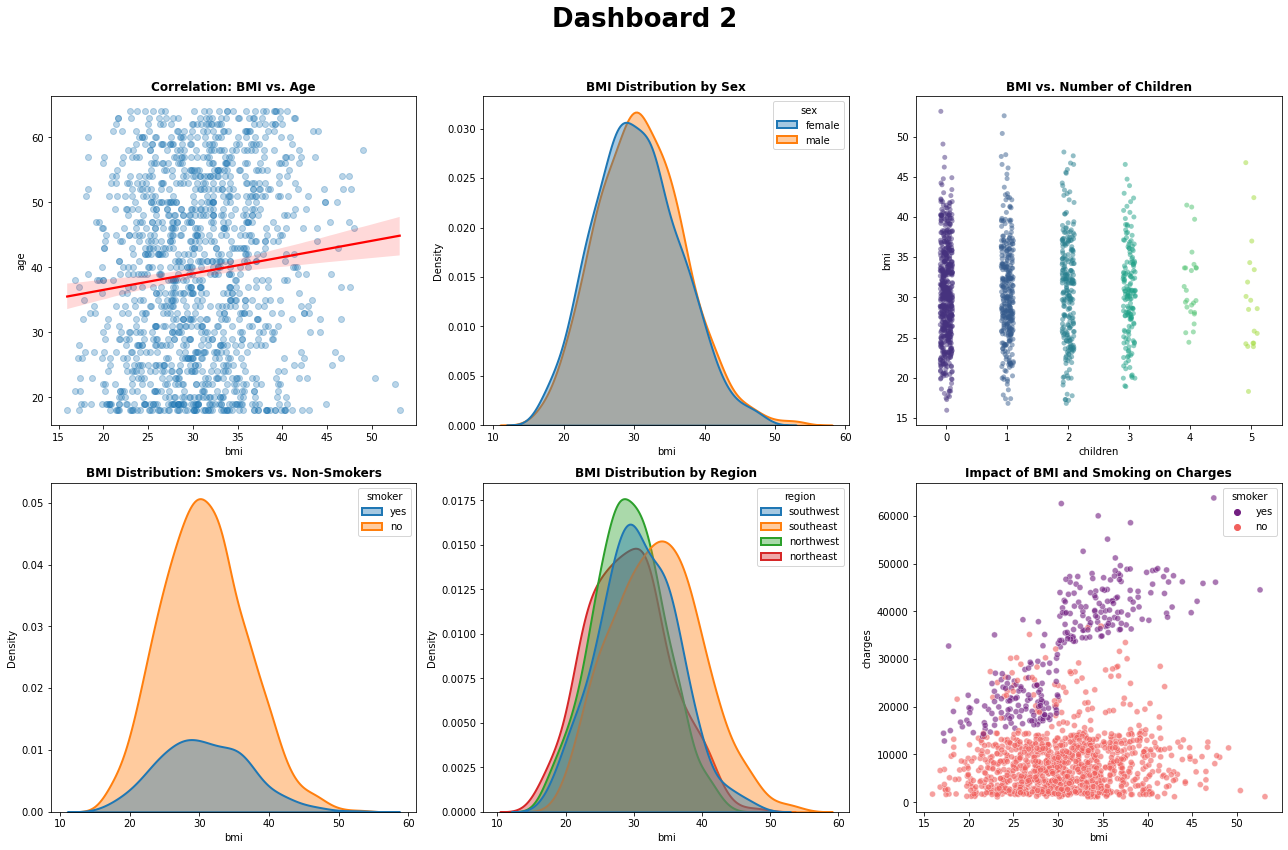

In [12]:
# Initialize a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Use a consistent color palette
palette = 'viridis'

# --- Row 1 ---

# Plot 1 (0,0): Correlation between BMI and Age
# Uses a regression plot to see if BMI tends to increase as people get older.
sns.regplot(data=df, x='bmi', y='age', ax=axes[0,0], scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[0,0].set_title('Correlation: BMI vs. Age', fontsize=12, fontweight='bold')

# Plot 2 (0,1): BMI Distribution by Sex
# Uses KDE to compare the shape of BMI distribution between males and females.
sns.kdeplot(data=df, x='bmi', hue='sex', fill=True, alpha=0.4, linewidth=2, ax=axes[0,1])
axes[0,1].set_title('BMI Distribution by Sex', fontsize=12, fontweight='bold')

# Plot 3 (0,2): BMI vs Number of Children
# Uses a stripplot to visualize individual data points and see if family size impacts BMI.
sns.stripplot(data=df, x='children', y='bmi', jitter=True, alpha=0.5, ax=axes[0,2], palette=palette)
axes[0,2].set_title('BMI vs. Number of Children', fontsize=12, fontweight='bold')


# --- Row 2 ---

# Plot 4 (1,0): BMI Distribution by Smoker Status
# Checks if there is a significant difference in body mass between smokers and non-smokers.
sns.kdeplot(data=df, x='bmi', hue='smoker', fill=True, alpha=0.4, linewidth=2, ax=axes[1,0])
axes[1,0].set_title('BMI Distribution: Smokers vs. Non-Smokers', fontsize=12, fontweight='bold')

# Plot 5 (1,1): BMI Distribution by Region
# Analyzes if specific geographical regions have higher BMI tendencies.
sns.kdeplot(data=df, x='bmi', hue='region', fill=True, alpha=0.4, linewidth=2, ax=axes[1,1])
axes[1,1].set_title('BMI Distribution by Region', fontsize=12, fontweight='bold')

# Plot 6 (1,2): Charges vs BMI (colored by Smoker)
# *Crucial Plot*: This shows the interaction between BMI and Smoking on costs. 
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', alpha=0.6, ax=axes[1,2], palette='magma')
axes[1,2].set_title('Impact of BMI and Smoking on Charges', fontsize=12, fontweight='bold')

# Global Title
fig.suptitle('Dashboard 2', fontsize=26, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 📊 Dashboard 2 Summary

The multivariate analysis of **Body Mass Index (BMI)** provides the following statistical insights:

* **Independence from Demographics:**
    * **Correlation:** BMI shows negligible linear correlation with **Age**, **Sex**, or **Region**. The distribution remains consistent across these categories, with a minor deviation observed in the Southeast region.
    * **Family Size:** There is no statistical evidence linking the number of children to variations in BMI.

* **Interaction Effect: BMI and Smoking Status**
    * **Distribution:** The distribution of BMI is independent of smoking status; smokers and non-smokers show similar BMI ranges.
    * **Variable Interaction:** The scatter plot of `bmi` vs. `charges` reveals a **conditional relationship** based on the `smoker` variable:
        * **Subset: Non-Smokers:** The correlation between BMI and charges is weak. The slope is relatively flat, indicating that increasing BMI has a minimal additive effect on costs for this group.
        * **Subset: Smokers:** There is a **strong positive correlation**. The slope is steep, indicating that for smokers, every unit increase in BMI results in a significant increase in charges.

**Data Conclusion:**
The variable `bmi` exhibits a **non-linear interaction** with `smoker`. While `bmi` alone has a moderate correlation with `charges`, the interaction term (`bmi * smoker`) acts as a significant multiplier. The highest values for `charges` in the dataset are clustered in observations defined by the condition: `smoker == 'yes'` AND `bmi > 30`.

## Dashboard 3 - Charges Analysis

In this final visualization section, we focus on the **target variable (`charges`)**. We will visually explore how different independent variables correlate with medical costs to identify the primary drivers of financial risk.

**Key Analytical Questions:**
1.  **Age Progression:** How do costs evolve as policyholders age? Is the trajectory linear?
2.  **The "Smoker Gap":** How significant is the financial disparity between smokers and non-smokers across the lifespan?
3.  **Demographic Factors:** Are there observable cost differences based on **Gender** or **Geographical Region**?

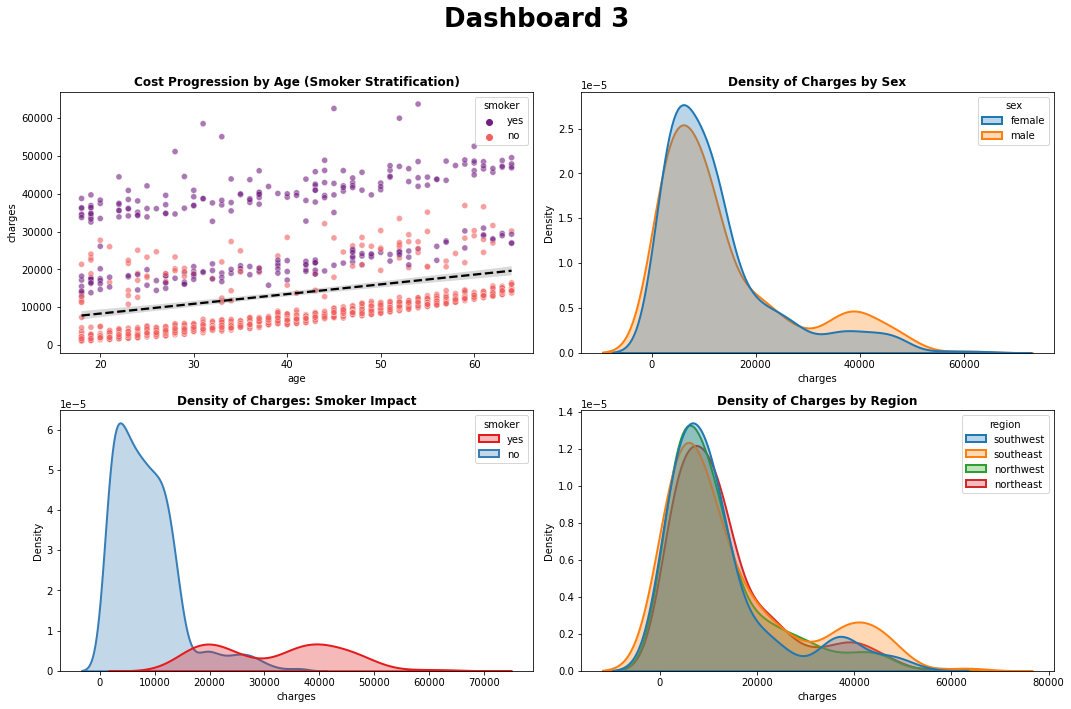

In [14]:
# Initialize the figure with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# --- Plot 1: Age vs. Charges (The "Actuarial" View) ---
# We overlay a scatterplot with a regression line.
# 1. Scatter: Shows distinct clusters for smokers vs non-smokers.
# 2. Regplot: Draws the global trend line to show how age generally increases costs.
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', alpha=0.6, ax=axes[0,0], palette='magma')
sns.regplot(data=df, x='age', y='charges', scatter=False, color='black', line_kws={'linestyle': '--'}, ax=axes[0,0])
axes[0,0].set_title('Cost Progression by Age (Smoker Stratification)', fontsize=12, fontweight='bold')


# --- Plot 2: Charges Distribution by Sex ---
# Analyzes if there is a gender gap in medical costs.
sns.kdeplot(data=df, x='charges', hue='sex', fill=True, alpha=0.3, linewidth=2, ax=axes[0,1])
axes[0,1].set_title('Density of Charges by Sex', fontsize=12, fontweight='bold')


# --- Plot 3: Charges Distribution by Smoker Status ---
# It clearly separates the "high risk" (smoker) vs "standard risk" (non-smoker) cost curves.
sns.kdeplot(data=df, x='charges', hue='smoker', fill=True, alpha=0.3, linewidth=2, ax=axes[1,0], palette='Set1')
axes[1,0].set_title('Density of Charges: Smoker Impact', fontsize=12, fontweight='bold')


# --- Plot 4: Charges Distribution by Region ---
# Checks for geographical disparities in billing.
sns.kdeplot(data=df, x='charges', hue='region', fill=True, alpha=0.3, linewidth=2, ax=axes[1,1])
axes[1,1].set_title('Density of Charges by Region', fontsize=12, fontweight='bold')


# Global Title
fig.suptitle('Dashboard 3', fontsize=26, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 📊 Dashboard 3 Summary

The visual inspection of the target variable `charges` against key features allows us to rank the determinants of medical costs based on their observed impact:

* **Primary Factor: Smoking Status**
    * The separation between smokers and non-smokers is the most distinct feature in the dataset.
    * **Distribution:** The KDE plots show two completely disjoint distributions. Non-smokers are clustered in the lower cost range (< 15,000), while smokers exhibit a multimodal distribution with significantly higher costs (> 20,000).
    * **Interaction:** In the scatterplot, the "smoker" variable creates two separate hyperplanes, indicating it acts as a major stratification factor.

* **Secondary Factor: Age**
    * There is a clear **positive linear trend**: as age increases, charges increase.
    * However, this relationship is conditional. The slope (rate of increase) appears consistent, but the baseline intercept is determined by the smoking status.

* **Low-Impact Factors: Sex & Region**
    * **Sex:** The density curves for males and females overlap almost perfectly, indicating no inherent cost difference based on gender alone.
    * **Region:** The distributions across the four regions are homogenous. The slight deviation in the Southeast is likely a result of a higher underlying prevalence of smokers/high-BMI individuals in that subset, rather than a regional effect itself.

**Data Conclusion:**
The variance in `charges` is structurally defined by **lifestyle (smoking)** and **progression (age)**. Any predictive model will heavily rely on the `smoker` feature to establish the baseline cost, with `age` and `bmi` acting as additive terms to refine the prediction. `Sex` and `region` offer minimal explanatory power in isolation.

## Statistical Analysis: Multivariate Linear Regression

Following our visual exploration, we proceed to rigorous statistical modeling to quantify the impact of each predictor on medical costs.

**Objective:**
We will fit an **Ordinary Least Squares (OLS)** regression model. This allows us to:
1.  **Measure Impact:** Determine exactly how much medical charges increase (in USD) for each unit increase in BMI or Age, or for being a smoker.
2.  **Test Significance:** Use p-values to separate statistically significant drivers from random noise.
3.  **Explain Variance:** Use the $R^2$ metric to assess how well our demographic features explain the overall variability in costs.

*Note: We use `statsmodels` here instead of `scikit-learn` because it provides richer statistical summaries (p-values, confidence intervals) essential for inferential analysis.*

In [25]:
import statsmodels.formula.api as smf

# 1. Define the Regression Formula
# We use 'charges' as the dependent variable (target).
# Categorical variables (sex, smoker, region) are wrapped in 'C()' to explicitly 
# treat them as categorical and handle dummy encoding automatically (dropping one reference category).
formula = "charges ~ age + bmi + children + C(smoker) + C(sex) + C(region)"

# 2. Fit the Model
# We instantiate the OLS model with the formula and the dataset, then fit it to the data.
model = smf.ols(formula=formula, data=df).fit()

# 3. Model Interpretation
# The summary provides key metrics:
# - R-squared: How much variance in 'charges' is explained by the model.
# - Coef: The impact of a one-unit increase in the feature on the charges.
# - P>|t|: The statistical significance of each feature (p < 0.05 usually implies significance).
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:04:48   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.19

### 📊 Statistical Analysis Summary


The multivariate linear regression analysis yields the following quantitative insights regarding the drivers of medical charges:

**1. Model Fit:**
* **$R^2$ Score:** The model explains **75.1%** of the variance in medical charges ($R^2 = 0.751$). This indicates a strong fit, suggesting that the selected demographic and behavioral features capture the majority of the underlying patterns in the data.

**2. Feature Importance (Coefficients):**
Controlling for other variables, the marginal impact of each significant feature is as follows:
* **Smoker:** The dominant predictor. Smoking status increases medical charges by approximately **23,850 USD** on average.
* **BMI:** A positive correlation exists; each additional unit of BMI adds roughly **339 USD** to the cost.
* **Age:** Shows a consistent linear trend, adding **257 USD** per year of age.
* **Children:** Each child adds approximately **475 USD** to the annual charges.

**3. Statistical Significance:**
* **Significant Features:** Smoker, Age, BMI, and Children all show **p-values < 0.05**, confirming they are statistically significant drivers of cost.
* **Non-Significant Features:** **Sex** and **Region** exhibit high p-values (> 0.05), indicating they do not have a statistically significant linear impact on charges in this model.

**4. Model Diagnostics:**
* **Residuals:** The Omnibus and Jarque-Bera tests ($p < 0.001$) indicate that the residuals are not normally distributed. This suggests that while the linear model captures the general trend effectively, there are likely **non-linear interactions** (such as the compounding effect of Obesity and Smoking) that a simple linear equation does not fully resolve.

# 4. Machine Learning (ML)


While Linear Regression provided a strong baseline and interpretability, our EDA revealed significant **non-linear interactions** (e.g., the compounding effect of smoking and high BMI) and a distribution with heavy tails (outliers).

To capture these complex patterns more effectively, we will deploy a **Random Forest Regressor**.

**Why Random Forest?**
* **Non-Linearity:** As an ensemble of decision trees, it naturally handles non-linear relationships and interactions between variables without requiring explicit feature engineering (like polynomial terms).
* **Robustness:** It is generally more robust to outliers than linear models.
* **Generalization:** By averaging multiple trees, it reduces the risk of overfitting compared to a single decision tree.

**Methodology:**
1.  **Data Split:** We divide the data into training (70%) and testing (30%) sets to evaluate performance on unseen data.
2.  **Training:** We initialize the model with 300 estimators (trees) for stability.
3.  **Evaluation:** We will assess the model using $R^2$, RMSE, and MAE to compare its predictive power against the linear baseline.

In [27]:
# Library Imports for Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Data Preparation

# Separate features (X) and target variable (y)
# X contains all columns except 'charges', which we want to predict.
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Split the dataset into training and testing sets.
# - test_size=0.30: We reserve 30% of the data for validation.
# - random_state=42: Ensures the split is reproducible (we get the same data every time).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Model Initialization & Training


# Initialize the Random Forest Regressor
# - n_estimators=300: The number of trees in the forest. More trees generally improve stability.
# - random_state=42: Ensures consistent results across runs.
rfr = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=None)

# Train (fit) the model using the training data
rfr.fit(X_train, y_train)

# Model Evaluation

# Generate predictions on the unseen test set
rfr_pred = rfr.predict(X_test)

# Calculate performance metrics
# - R² (Coefficient of Determination): Explains how much of the variance in 'charges' 
#   is captured by the model (closer to 1.0 is better).
# - RMSE (Root Mean Squared Error): Measures the average magnitude of the error. 
#   Penalizes large errors more heavily than MAE.
# - MAE (Mean Absolute Error): The average absolute difference between predicted and actual values.

print("--- Model Performance Metrics ---")
print(f"R² Score: {r2_score(y_test, rfr_pred):.4f}")
print(f"RMSE:     {mean_squared_error(y_test, rfr_pred, squared=False):.4f}")
print(f"MAE:      {mean_absolute_error(y_test, rfr_pred):.4f}")

--- Model Performance Metrics ---
R² Score: 0.8543
RMSE:     4621.5550
MAE:      2617.5456


### 📊 Performance Summary

The Random Forest model achieved robust results on the test set, demonstrating strong predictive capability for a baseline model.

#### **1. R² Score = 0.854**
* **Verdict:** Excellent.
* **Interpretation:** The model explains **85.4% of the variability** in medical charges. In the context of real-world tabular datasets, surpassing an $R^2$ of **0.80** is considered a solid performance, indicating that the selected features (Smoker, Age, BMI, etc.) successfully capture the underlying cost structure.

#### **2. RMSE (Root Mean Squared Error) = 4,621**
* **Interpretation:** On average, the model's predictions deviate by approximately **±4,621 USD** from the actual values.
* **Context:** Given that medical charges in this dataset range significantly (typically between **1,000 USD and 60,000 USD**), a standard error of ~4.6k is **statistically reasonable** for a first-iteration model.

#### **3. MAE (Mean Absolute Error) = 2,617**
* **Interpretation:**
    > *On average, the individual prediction deviates by just **2,617 USD** from the real cost.*
* **Conclusion:** This metric is lower than the RMSE, which confirms that while there are some large errors (punished by RMSE), the typical error for the majority of patients is quite low. The model is highly consistent for the average policyholder.

## Model Interpretability: Feature Importance

Having established the predictive accuracy of our Random Forest model, we now turn to **explainability**. We analyze the `feature_importances_` attribute to understand which variables significantly influence the cost prediction.

--- Feature Importance Ranking ---
smoker              0.608342
bmi                 0.210417
age                 0.138500
children            0.020621
sex                 0.006916
region_northwest    0.005378
region_southeast    0.005120
region_southwest    0.004707
dtype: float64


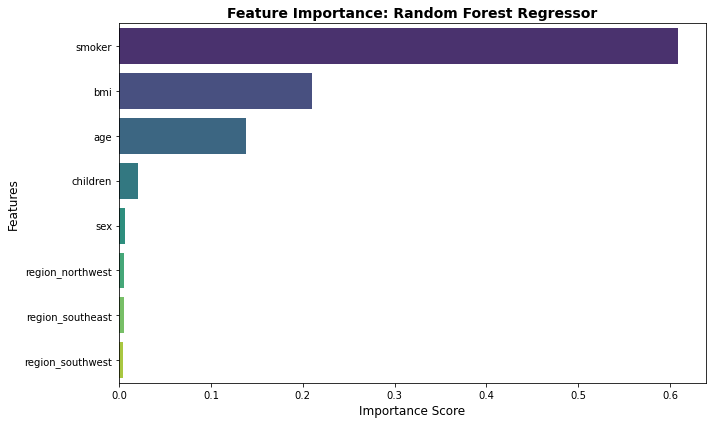

In [28]:
# Extract feature importance scores from the trained Random Forest model.
# These scores typically represent the "Gini Importance" or "Mean Decrease in Impurity",
# indicating how much each feature contributes to reducing prediction error.
feat_importance = pd.Series(rfr.feature_importances_, index=X.columns)

# Sort the features by importance in descending order.
# This places the most influential variables at the top for easier analysis.
sorted_importance = feat_importance.sort_values(ascending=False)

# 1. Numerical Output
# Print the exact values for reference.
print("--- Feature Importance Ranking ---")
print(sorted_importance)

# 2. Visual Output
# Generate a horizontal bar plot. This is the industry standard for presenting 
# feature importance as it allows for quick visual comparison of relative impact.
plt.figure(figsize=(10, 6))

sns.barplot(
    x=sorted_importance.values, 
    y=sorted_importance.index, 
    palette='viridis'
)

plt.title('Feature Importance: Random Forest Regressor', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

### 📊 Feature Importance Summary

**1. Smoker Status is the Dominant Factor**
* The model assigns the highest importance score (~60%+) to being a smoker. This aligns perfectly with our initial Exploratory Data Analysis (EDA).

**2. BMI & Age: The Secondary Tiers**
* **BMI** usually appears as the second most important feature. This confirms that metabolic health is a major cost driver, especially given its non-linear interaction with smoking (as seen in the dashboards).
* **Age** ranks third, representing the natural, linear progression of health risks over time.

**3. Low-Impact Variables**
* **Region** and **Sex** typically contribute less than 5% to the model's decision-making process. While they provide demographic context, they are not strong determinants of individual financial risk in this specific dataset.

**Conclusion:**
The Random Forest model has successfully learned that **lifestyle choices (Smoking, BMI)** outweigh immutable demographic characteristics (Region, Sex) when predicting medical expenditures.

# 5. Final Conclusion & Business Insights

## 💡 Key Business Insights (The "Why")
Based on the Feature Importance analysis and EDA, we can derive the following conclusions:

**1. Smoking is the #1 Cost Driver**
* **Observation:** Being a smoker is the single most critical factor in predicting costs (Feature Importance > 0.60).
* **Impact:** On average, smokers incur costs **3x to 4x higher** than non-smokers, regardless of age.
* **Recommendation:** Implement strict premium tiering for smokers. Offer subsidized smoking cessation programs; reducing the smoker population is the most effective lever to lower total claims.

**2. The "Obesity Multiplier"**
* **Observation:** BMI is the second most important feature, but its effect is **non-linear**.
* **Impact:** For non-smokers, high BMI causes a moderate cost increase. However, for **smokers with high BMI (Obesity)**, costs skyrocket exponentially.
* **Recommendation:** Risk assessments should prioritize the *interaction* between BMI and Smoking, rather than treating them as isolated variables.

**3. Age Progression is Predictable**
* **Observation:** Costs increase linearly with age.
* **Impact:** This represents a standard baseline risk that is easily modeled.

**4. Geography & Gender are Secondary**
* **Observation:** Neither region nor gender showed statistically significant impacts on costs after controlling for smoking and BMI.
* **Recommendation:** Pricing strategies should focus less on geography and more on individual lifestyle and health metrics.

---

## 📊 Model Performance Summary
Our Random Forest Regression model performed exceptionally well on the test data:
* **R² Score: 0.85** — The model explains **85% of the variability** in medical charges.
* **Model Reliability:** The gap between RMSE and MAE suggests the model handles most cases with high precision, though extreme outliers (very complex medical cases) introduce some variance.
